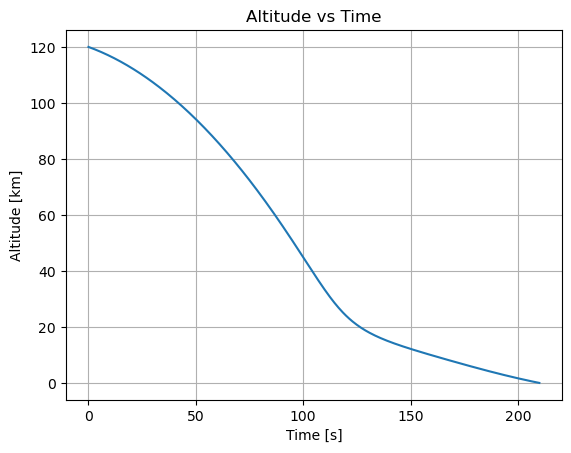

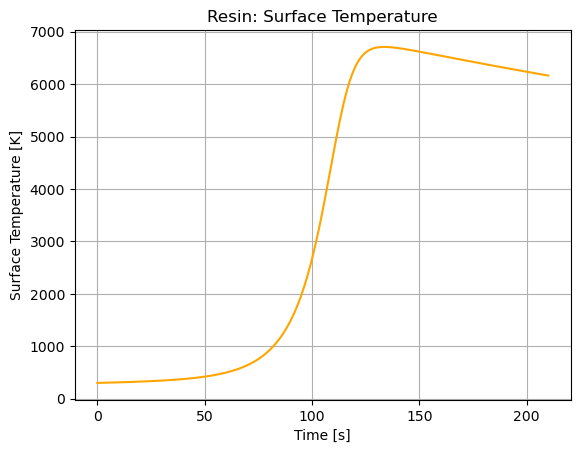

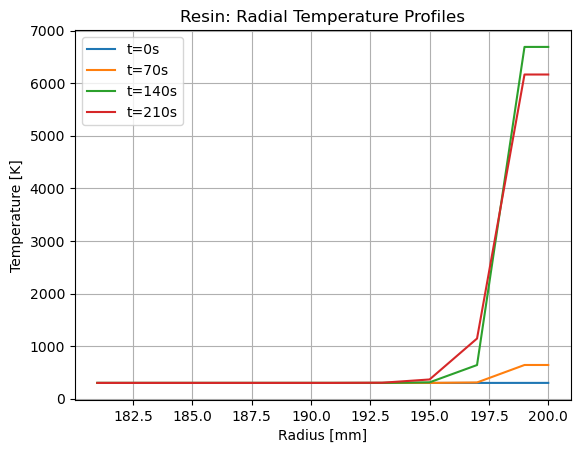

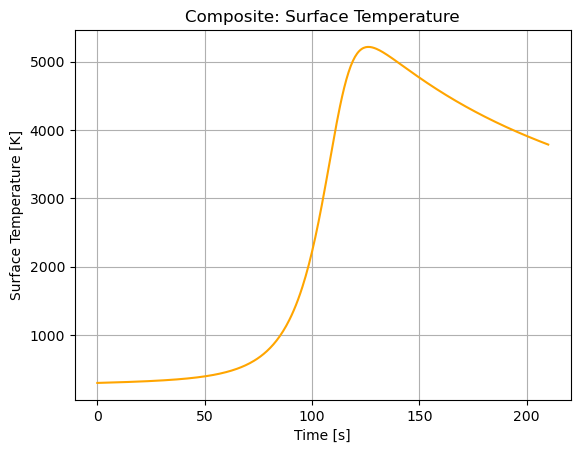

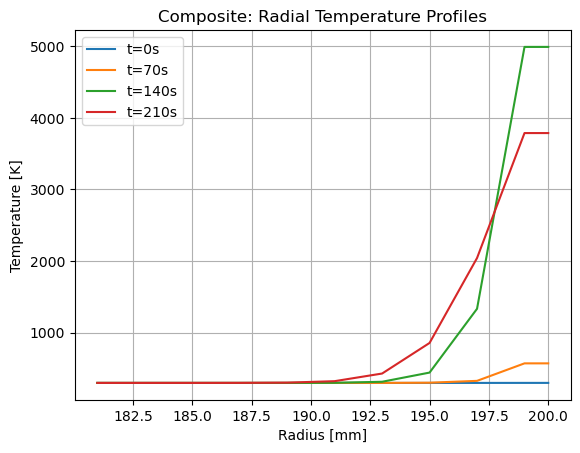

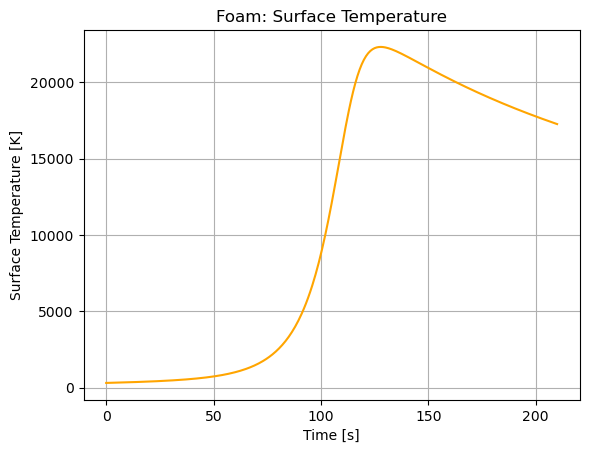

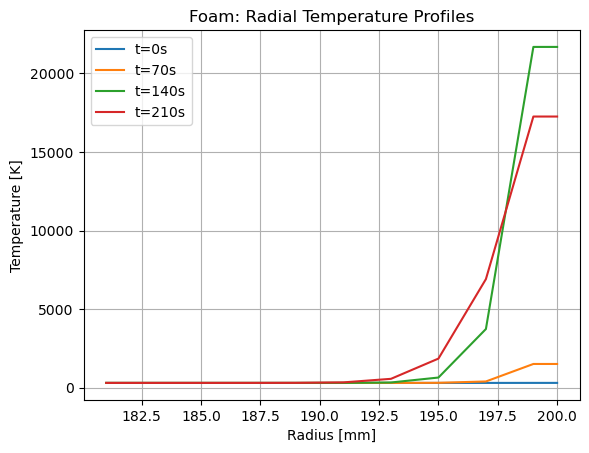

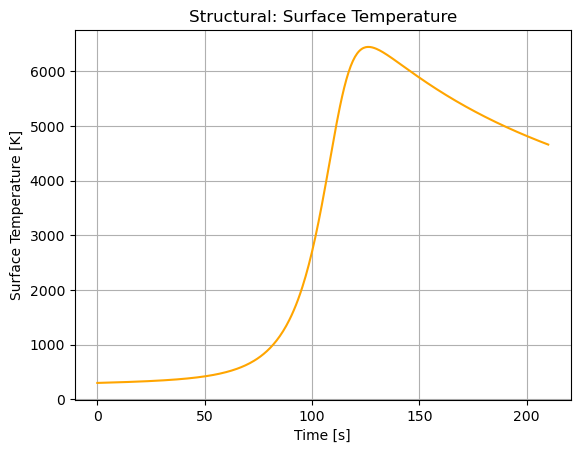

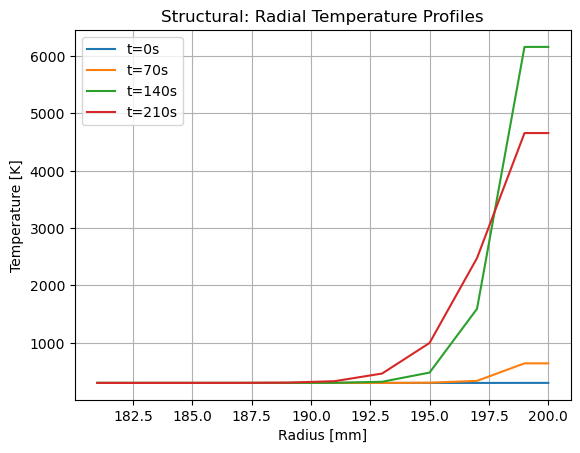

In [ ]:
import numpy as np
import math as m
import matplotlib.pyplot as plt

"""
Implemented:
    - Reentry Trajectory (Propagated using RK4)
        + Atmospheric Density Changes
        + Gravity changes

    - Surface forcing eq (Sutton-Graves Stagnation Point Eq)

    - Discretezation Matrix A



Requires:
    - More accurate material properties
    - Multilayered TPS
    - Increased dr resolution
"""


# Physical constants
R_EARTH = 6371000.0
G0 = 9.81


# Atmosphere & gravity
def atmosphere_rho(h):
    rho0 = 1.225
    H = 7200.0
    h = np.maximum(h, 0.0)
    return rho0 * np.exp(-h / H)

def gravity(h):
    return G0 * (R_EARTH / (R_EARTH + np.maximum(h, 0.0)))**2


# Sutton–Graves heat flux
def sutton_graves_q(h, V, Rn, K=1.e-4):
    rho = atmosphere_rho(h)
    return K * np.sqrt(rho) * np.abs(V)**3 / np.sqrt(Rn)


# Material database
MATERIAL_DB = {
    "Resin":        dict(rho=1040.0, cp=1506.0, k=0.09),
    "Composite":    dict(rho=1800.0, cp=1000.0, k=0.5),
    "Foam":         dict(rho=300.0,  cp=1400.0, k=0.08),
    "Structural":   dict(rho=1600.0, cp=900.0,  k=0.4),
}

def compute_single_material_layers(material):
    m = MATERIAL_DB[material]
    return [
        (TPS_outer, m["rho"], m["cp"], m["k"]),
        (0.0, 2700.0, 900.0, 200.0),
    ]


# Material assignment
def assign_material_properties(r, layers):
    rho = np.zeros_like(r)
    cp  = np.zeros_like(r)
    k   = np.zeros_like(r)
    for i, ri in enumerate(r):
        for r_outer, rh, c, kk in layers:
            if ri <= r_outer:
                rho[i], cp[i], k[i] = rh, c, kk
                break
    return rho, cp, k


# Spherical conduction operator
def build_spherical_operator_uniform(N, R, layers):
    dr = R / N
    r = np.arange(N) * dr + dr/2
    rho, cp, k = assign_material_properties(r, layers)
    A = np.zeros((N, N))

    for i in range(N):
        if i == 0:
            kf = 2*k[i]*k[i+1]/(k[i]+k[i+1])
            a = kf/(rho[i]*cp[i])
            A[i,i] = -6*a/dr**2
            A[i,i+1] = 6*a/dr**2
        elif i == N-1:
            rm = r[i] - dr/2
            kf = 2*k[i-1]*k[i]/(k[i-1]+k[i])
            a = kf/(rho[i]*cp[i])
            A[i,i-1] = a*rm**2/(r[i]**2*dr**2)
            A[i,i] = -a*rm**2/(r[i]**2*dr**2)
        else:
            rm, rp = r[i]-dr/2, r[i]+dr/2
            km = 2*k[i-1]*k[i]/(k[i-1]+k[i])
            kp = 2*k[i]*k[i+1]/(k[i]+k[i+1])
            am, ap = km/(rho[i]*cp[i]), kp/(rho[i]*cp[i])
            A[i,i-1] = am*rm**2/(r[i]**2*dr**2)
            A[i,i] = -(am*rm**2+ap*rp**2)/(r[i]**2*dr**2)
            A[i,i+1] = ap*rp**2/(r[i]**2*dr**2)

    return A, r, dr, rho, cp, k


# Conduction solver
def trapezoid_step(u, dt, A, q, r, dr, rho, cp, R):
    I = np.eye(len(u))
    RHS = (I + 0.5*dt*A) @ u

    r_c = r[-1]
    r_i = r_c - dr/2
    V = 4/3*np.pi*(R**3 - r_i**3)
    A_s = 4*np.pi*R**2

    RHS[-1] += dt*(q*A_s)/(rho[-1]*cp[-1]*V)
    return np.linalg.solve(I - 0.5*dt*A, RHS)

def integrate_conduction(u0, A, q_array, dt, r, dr, rho, cp, R):
    u = u0.copy()
    sol = []
    for q in q_array:
        u = trapezoid_step(u, dt/10, A, q, r, dr, rho, cp, R)
        sol.append(u.copy())
    return np.array(sol)


# Reentry dynamics
def rk4(f, t, y, dt, *args):
    k1 = f(t,y,*args)
    k2 = f(t+dt/2,y+dt/2*k1,*args)
    k3 = f(t+dt/2,y+dt/2*k2,*args)
    k4 = f(t+dt,y+dt*k3,*args)
    return y + dt*(k1+2*k2+2*k3+k4)/6

def reentry_rhs(t, y, m, Cd, A):
    h,vx,vz = y
    h = max(h,0)
    rho = atmosphere_rho(h)
    g = gravity(h)
    V = np.hypot(vx,vz)
    D = 0 if V<1e-9 else 0.5*rho*V**2*Cd*A/m
    return np.array([vz, -D*vx/V if V>0 else 0, -g-D*vz/V if V>0 else -g])

def integrate_reentry(y0):
    t,y = 0,y0.copy()
    T,Y=[0],[y.copy()]
    while y[0]>0 and t<t_final:
        y=rk4(reentry_rhs,t,y,dt,200,1.2,np.pi*R_sphere**2)
        y[0]=max(y[0],0)
        t+=dt
        T.append(t); Y.append(y.copy())
    return np.array(T),np.array(Y)


# Main simulation + plots
def run_simulation(material, first):
    layers = compute_single_material_layers(material)
    y0 = np.array([Alt_0 ,V_0*np.cos(np.radians(-2)),V_0*np.sin(np.radians(-2))])
    times, Y = integrate_reentry(y0)

    altitudes = Y[:,0]
    V = np.linalg.norm(Y[:,1:],axis=1)
    q_array = sutton_graves_q(altitudes,V,R_sphere)

    A,r,dr,rho,cp,k = build_spherical_operator_uniform(N,R_sphere,layers)
    sol_T = integrate_conduction(np.ones(N)*300,A,q_array,dt,r,dr,rho,cp,R_sphere)

    T_surface = sol_T[:,-1]


    # Plots
    if first == 1:
        plt.figure()
        plt.plot(times, altitudes/1000)
        plt.xlabel("Time [s]")
        plt.ylabel("Altitude [km]")
        plt.title("Altitude vs Time")
        plt.grid()

    plt.figure()
    plt.plot(times, T_surface, color="orange")
    plt.xlabel("Time [s]")
    plt.ylabel("Surface Temperature [K]")
    plt.title(f"{material}: Surface Temperature")
    plt.grid()

    plt.figure()
    r_mask = r >= 0.180
    r_plot = r[r_mask]
    for idx in np.linspace(0,len(times)-1,4,dtype=int):
        plt.plot(np.hstack([r_plot,R_sphere])*1000,
                 np.hstack([sol_T[idx,r_mask],T_surface[idx]]),
                 label=f"t={times[idx]:.0f}s")
    plt.xlabel("Radius [mm]")
    plt.ylabel("Temperature [K]")
    plt.title(f"{material}: Radial Temperature Profiles")
    plt.legend()
    plt.grid()

    plt.show()


# Simulation / numerical parameters
R_sphere = 0.2          # m
N = 100                 # radial cells (Set to 100 for testing, ought to be higher for resolution purposes but takes much longer)
t_final = 400.0         # s (Set to ensure landing within timeframe)
dt = 0.5                # s

TPS_inner = 0.195
TPS_outer = R_sphere
Alt_0 = 120000          # m 
V_0 = 8000              # m/s


# Run
if __name__=="__main__":
    first = 1
    for mat in MATERIAL_DB:
        run_simulation(mat, first)
        first = 0

